# Plotting Maps &mdash; COVID-19 Cases
## Requirements
You will need to install the `cartopy` Python package as well as some additional dependencies. Follow the instructions [here](https://scitools.org.uk/cartopy/docs/latest/installing.html#installing) for setup.

## Data Wrangling
In this notebook, we will use the European Centre for Disease Prevention and Control's (ECDC) [daily number of new reported cases of COVID-19 by country worldwide dataset](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide) most recent file. Should this no longer work, read in the data from the chapter which is a snapshot collected on September 19, 2020:

```python
df = pd.read_csv('data/covid19_cases.csv')
```

First, we collect the data and summarize it to get cumulative cases by country:

In [1]:
import pandas as pd

# read in the latest COVID-19 data from the European Centre for Disease Prevention and Control (ECDC)
df = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv').rename(columns={'cases_weekly': 'cases'})

# summarize the COVID-19 data to get cumulative cases by country
total_cases_per_country = df.groupby('countriesAndTerritories').cases.sum().rename(lambda x: x.replace('_', ' '), axis=0)

## Plotting Countries with Matplotlib and Cartopy

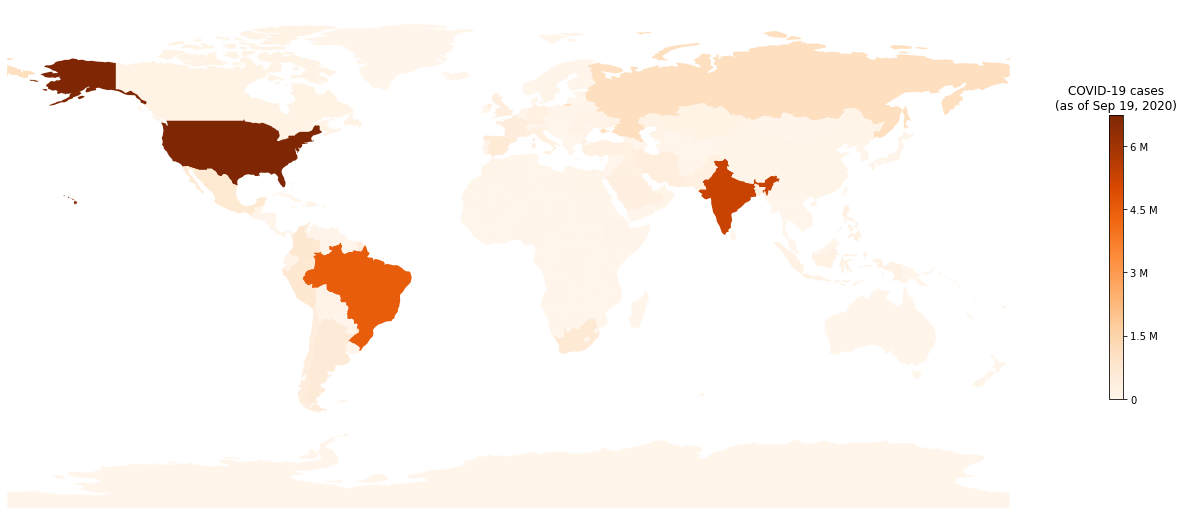

In [2]:
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import EngFormatter, MaxNLocator
import numpy as np
import color_utils

# build layout
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(1, 10)
map_subplot = fig.add_subplot(gs[0, :9], projection=ccrs.PlateCarree())
cbar_subplot = fig.add_subplot(gs[0, 9])

# select the colormap; remember this is a callable so colormap(0.5) 
# will give us the color at the midpoint, so we will need to scale 
# the cases to be in [0, 1] (we will divide by the max number of cases)
colormap = cm.get_cmap('Oranges')

# names that are different in the shapefile versus the COVID-19 data
alternate_names = {
    'Tanzania': 'United Republic of Tanzania',
    'The Bahamas': 'Bahamas',
    'Falkland Islands': 'Falkland Islands (Malvinas)',
    'Somaliland': 'Somalia',
    'Republic of Macedonia': 'North Macedonia',
    'East Timor': 'Timor Leste',
    'Ivory Coast': 'Cote dIvoire',
    'Guinea-Bissau': 'Guinea Bissau',
    'Republic of the Congo': 'Democratic Republic of the Congo',
    'eSwatini': 'Eswatini',
    'The Gambia': 'Gambia',
    "People's Republic of China": 'China',
    'Brunei': 'Brunei Darussalam',
    'Czech Republic': 'Czechia'
}

# get shapefile for drawing the map
countries_shp = shpreader.natural_earth(
    resolution='110m', category='cultural', name='admin_0_countries'
)

# add countries to the plot, shading them by the number of cases of COVID-19
for country in shpreader.Reader(countries_shp).records():
    country_name = country.attributes['NAME_EN']
    country_name = alternate_names.get(country_name, country_name)
    map_subplot.add_geometries(
        [country.geometry], 
        ccrs.PlateCarree(),
        facecolor=colormap(total_cases_per_country.get(country_name, 0) / total_cases_per_country.max()),
        label=country_name
    )

# create a colorbar for the map
cbar = color_utils.draw_cmap(
    colormap, 
    values=np.array([np.concatenate([[0], total_cases_per_country])]), 
    orientation='vertical', 
    ax=cbar_subplot
)
cbar.ax.yaxis.set_major_formatter(EngFormatter())
cbar.ax.yaxis.set_major_locator(MaxNLocator(5))
max_full_day = pd.to_datetime(df.dateRep, format='%d/%m/%Y').max()
cbar.ax.set_title(f'COVID-19 cases\n(as of {max_full_day.strftime("%b %d, %Y")})')

# remove the box around the map
for spine in map_subplot.spines:
    map_subplot.spines[spine].set_visible(False)